<a href="https://colab.research.google.com/github/umangjpatel/g20-machine-learning/blob/main/RN_50_SIPAKDMED_PROGRESSIVE_LEARNING_0.98_Kappa_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! [ -e /content ] && pip install -Uqq fastai
! pip install kaggle

     |████████████████████████████████| 194kB 8.7MB/s 
     |████████████████████████████████| 12.8MB 192kB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.


In [2]:
from google.colab import files
from pathlib import Path
from fastai.vision.all import *
from fastai.callback.fp16 import *

kaggle_key = (Path(".")) / "kaggle.json"
if not kaggle_key.exists():
  uploaded = files.upload()
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download umangjpatel/sipakmed-wsi -p="dataset" --unzip 

100% 6.00G/6.01G [02:17<00:00, 30.4MB/s]
100% 6.01G/6.01G [02:17<00:00, 46.8MB/s]


In [4]:
root_path = Path(".")
dataset_path = root_path / "dataset"

print("Categories\t\t  | # of images")
print("-" * 40)
for d in dataset_path.iterdir():
  img_count = len([x for x in d.iterdir() if x.is_file() and x.suffix == ".bmp"])
  spaces = " " if "_" in d.name else "\t\t "
  print(f"{d.name}{spaces} | {img_count}")

Categories		  | # of images
----------------------------------------
koilocytotic		  | 238
superficial_intermediate  | 126
parabasal		  | 108
metaplastic		  | 271
dyskeratotic		  | 223


In [6]:
dls_224 = ImageDataLoaders.from_folder(path = dataset_path, valid_pct=0.2, 
                                   item_tfms=Resize(448),
                                   batch_tfms = aug_transforms(size = 224,
                                                               flip_vert = True,
                                                               max_zoom = 1.0, max_rotate = 60.0, max_warp = 0.0),
                                   bs = 8,
                                   seed = 42)
dls_224.valid_ds.items[:3] 

[Path('dataset/superficial_intermediate/123.bmp'),
 Path('dataset/superficial_intermediate/075.bmp'),
 Path('dataset/metaplastic/253.bmp')]

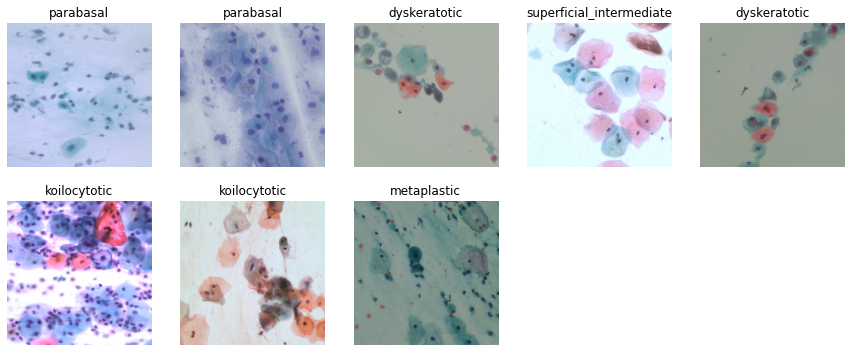

In [7]:
dls_224.show_batch(nrows = 2, ncols = 5)

In [8]:
learn = cnn_learner(dls_224, resnet50, metrics = [accuracy, error_rate, Precision(average='macro'), Recall(average='macro'), FBeta(beta=0.5, average = 'macro'), CohenKappa(weights='quadratic')], model_dir= '../models/').to_fp16()


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [9]:
learn.fit_one_cycle(10, cbs= EarlyStoppingCallback(monitor='accuracy', patience=15))

SuggestedLRs(lr_min=4.365158383734525e-06, lr_steep=7.585775847473997e-07)

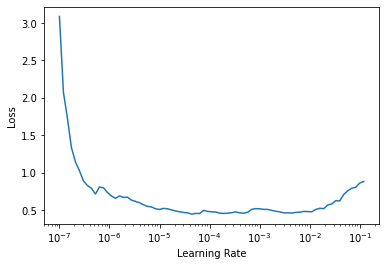

In [10]:
learn.lr_find()

In [11]:
learn.save('sipakmed-stage-1-64')

Path('dataset/../models/sipakmed-stage-1-64.pth')

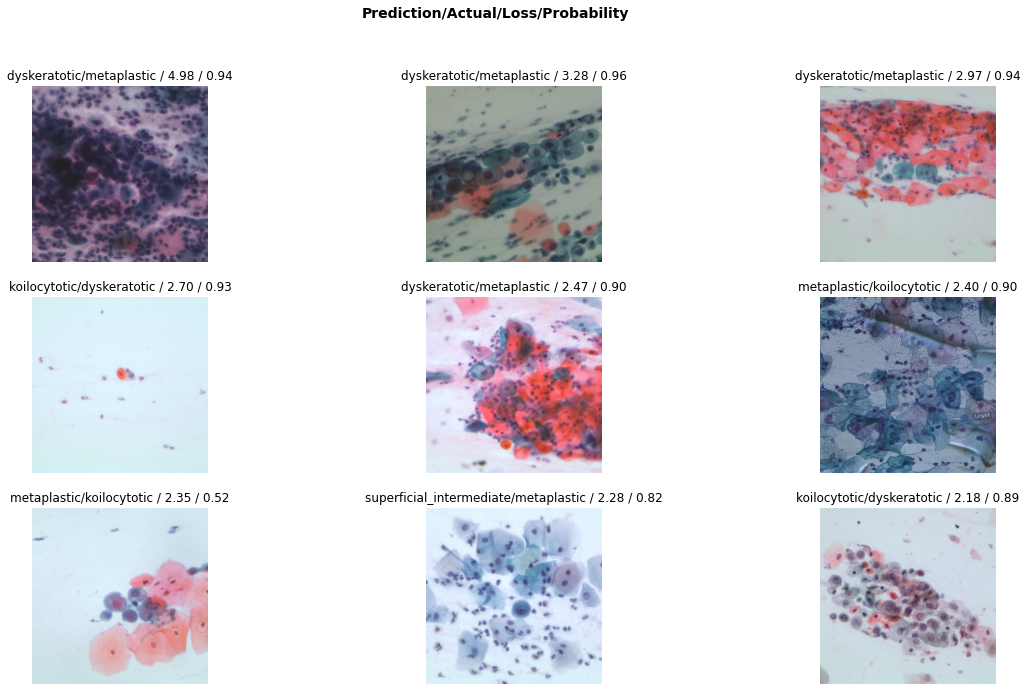

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(20,11))

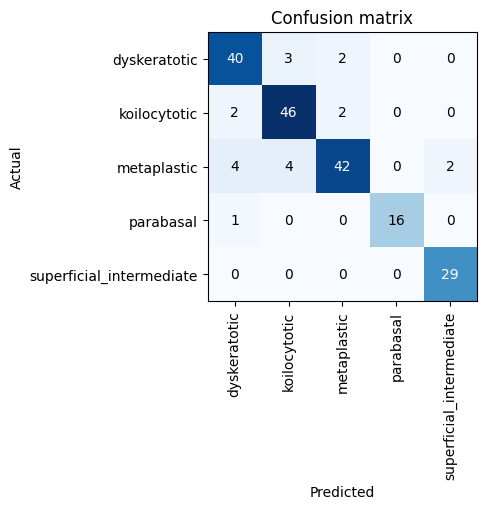

In [14]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=100)

In [15]:
learn.load('/content/models/sipakmed-stage-1-64')

In [16]:
learn.unfreeze()

SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=9.12010818865383e-07)

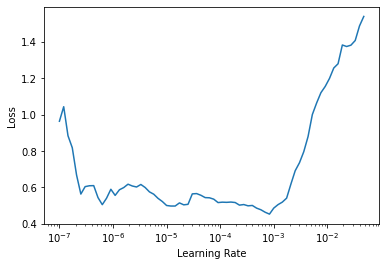

In [20]:
learn.lr_find()

In [21]:
learn.fit(40, 5e-05,cbs=EarlyStoppingCallback(monitor='accuracy', patience=15))

No improvement since epoch 8: early stopping


In [22]:
learn.save('sipakmed-stage-2-224')

Path('dataset/../models/sipakmed-stage-2-224.pth')

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

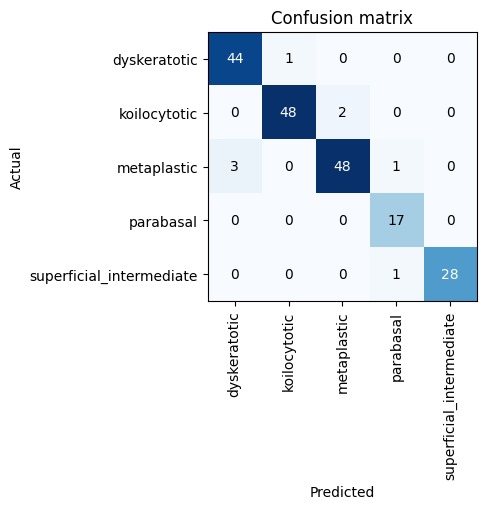

In [24]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=100)

In [25]:
dls_512 = ImageDataLoaders.from_folder(path = dataset_path, valid_pct=0.2, 
                                   item_tfms=Resize(1024),
                                   batch_tfms = aug_transforms(size = 512,
                                                               flip_vert = True,
                                                               max_zoom = 1.0, max_rotate = 60.0, max_warp = 0.0),
                                   bs = 8,
                                   seed = 42)
dls_512.valid_ds.items[:3] 

[Path('dataset/superficial_intermediate/123.bmp'),
 Path('dataset/superficial_intermediate/075.bmp'),
 Path('dataset/metaplastic/253.bmp')]

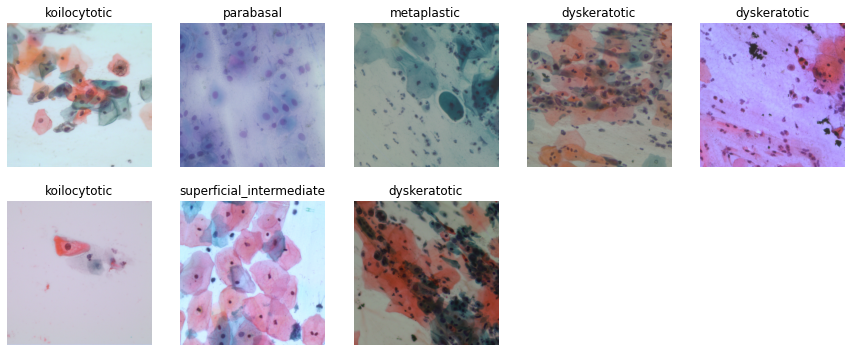

In [26]:
dls_512.show_batch(nrows = 2, ncols = 5)

In [27]:
learn.load('sipakmed-stage-2-224')

In [28]:
learn.unfreeze()

SuggestedLRs(lr_min=6.918309736647643e-07, lr_steep=7.585775847473997e-07)

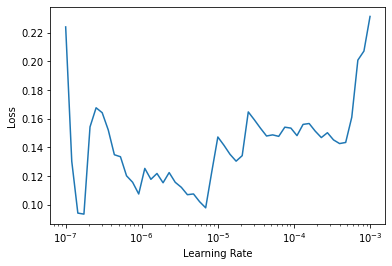

In [29]:
learn.lr_find()

In [30]:
learn.fit(40, 7.0e-07,cbs=EarlyStoppingCallback(monitor='accuracy', patience=15))

No improvement since epoch 2: early stopping


In [31]:
learn.save('sipakmed-stage-1-512')

Path('dataset/../models/sipakmed-stage-1-512.pth')

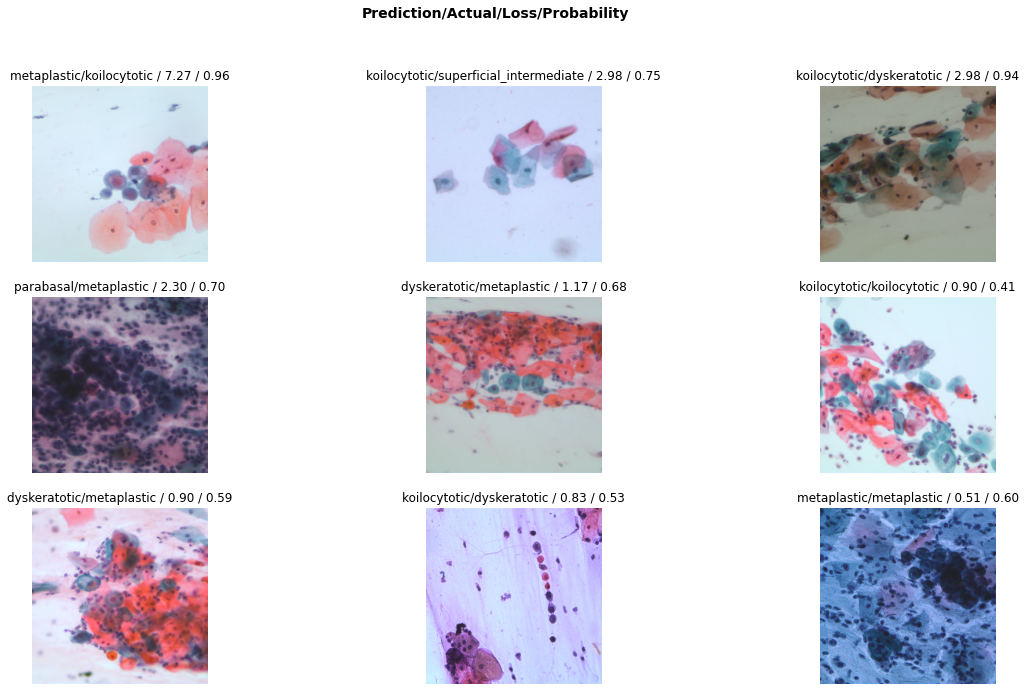

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(20,11))

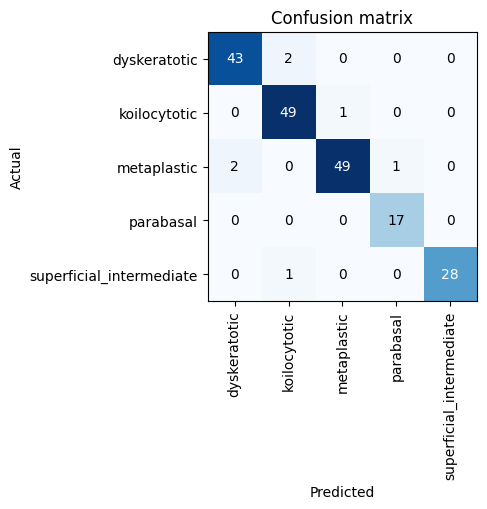

In [33]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=100)

In [34]:
learn.unfreeze()

SuggestedLRs(lr_min=3.0199516913853586e-06, lr_steep=1.3182567499825382e-06)

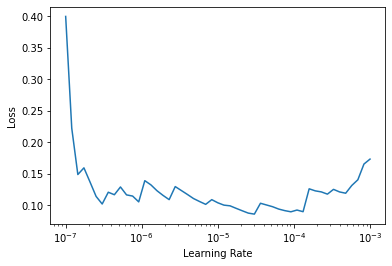

In [36]:
learn.lr_find()

In [37]:
learn.fit(40, 3.0e-06,cbs=EarlyStoppingCallback(monitor='accuracy', patience=15))

No improvement since epoch 11: early stopping


In [38]:
learn.save('sipakmed-stage-2-512')

Path('dataset/../models/sipakmed-stage-2-512.pth')

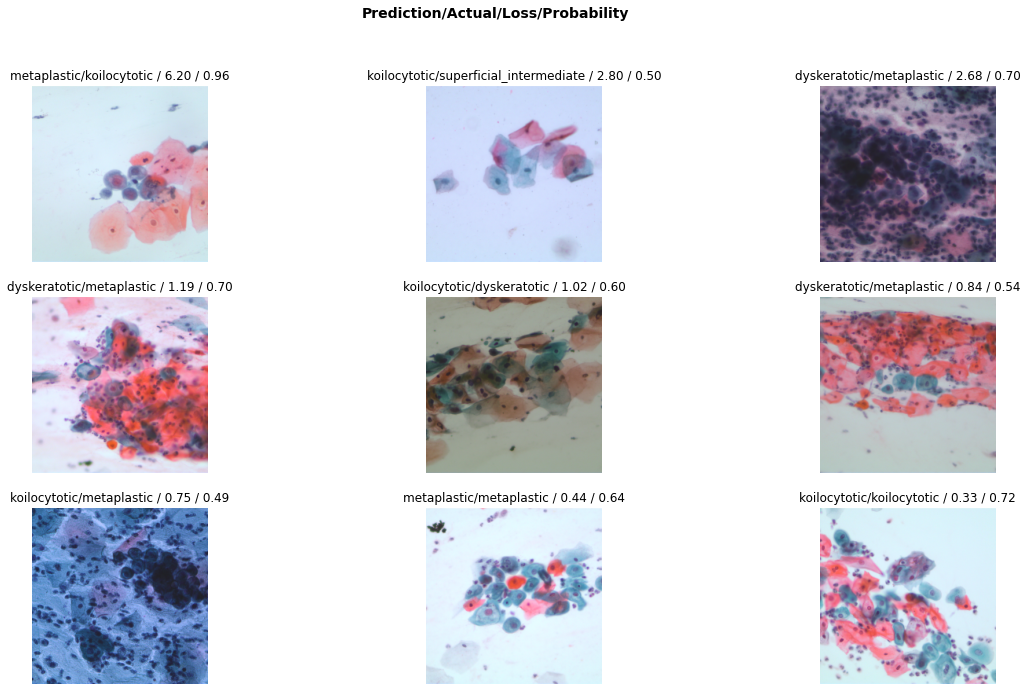

In [39]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(20,11))

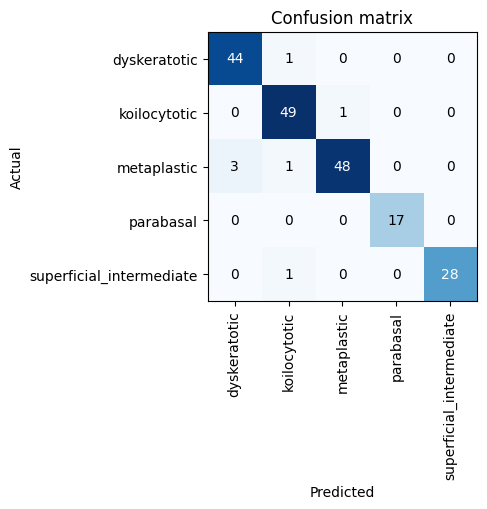

In [40]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=100)

In [66]:
dls_1024 = ImageDataLoaders.from_folder(path = dataset_path, valid_pct=0.2, 
                                   item_tfms=Resize(2048),
                                   batch_tfms = aug_transforms(size = 1024,
                                                               flip_vert = True,
                                                               max_zoom = 1.0, max_rotate = 60.0, max_warp = 0.0),
                                   bs = 8,
                                   seed = 42)
dls_1024.valid_ds.items[:3] 

[Path('dataset/superficial_intermediate/123.bmp'),
 Path('dataset/superficial_intermediate/075.bmp'),
 Path('dataset/metaplastic/253.bmp')]

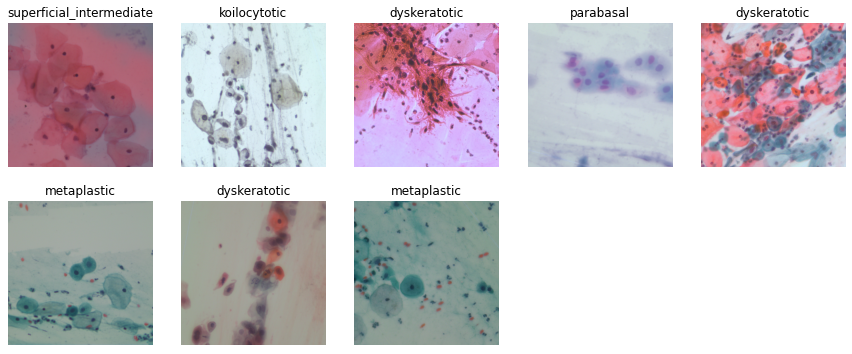

In [67]:
dls_1024.show_batch(nrows = 2, ncols = 5)

In [68]:
learn.load('sipakmed-stage-2-512')

In [69]:
learn.unfreeze()

SuggestedLRs(lr_min=1.58489319801447e-07, lr_steep=7.585775892948732e-05)

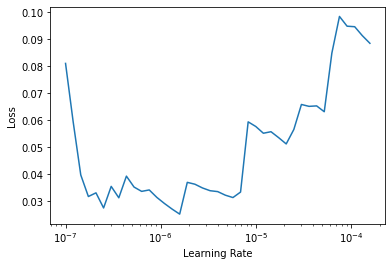

In [70]:
learn.lr_find()

In [71]:
learn.fit(40, 6e-07,cbs=EarlyStoppingCallback(monitor='accuracy', patience=15))

No improvement since epoch 5: early stopping


In [72]:
learn.save('sipakmed-stage-1-1024')

Path('dataset/../models/sipakmed-stage-1-1024.pth')

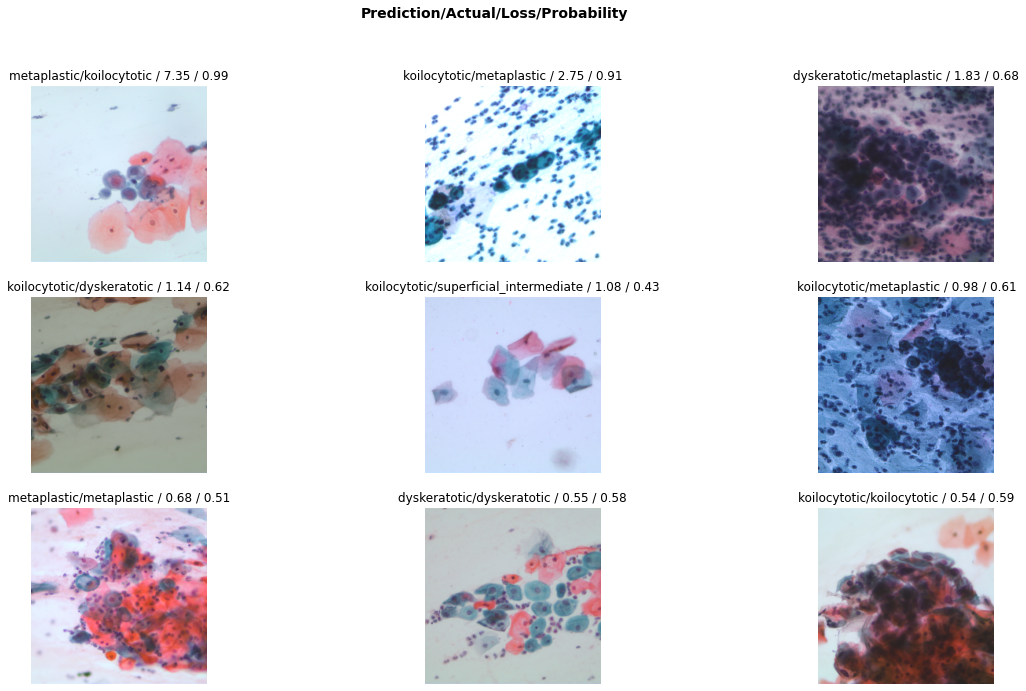

In [73]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(20,11))

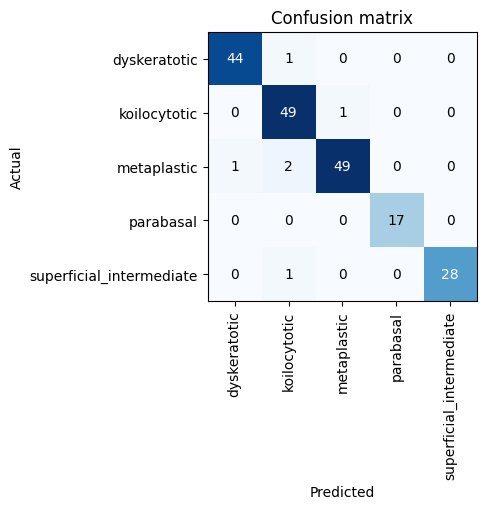

In [74]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=100)

In [75]:
learn.load('sipakmed-stage-1-1024')

In [76]:
learn.unfreeze()

SuggestedLRs(lr_min=3.6307807022240014e-06, lr_steep=6.309573450380412e-07)

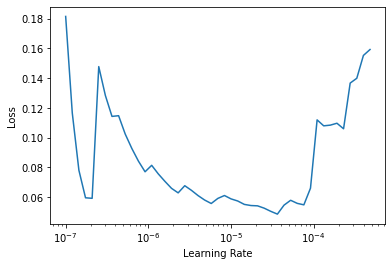

In [77]:
learn.lr_find()

In [ ]:
learn.fit(40, 1e-05,cbs=EarlyStoppingCallback(monitor='accuracy', patience=15))